In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# For final zoom-in diagrams
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

############################################
# 1. GLOBAL SETTINGS
############################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35
NUM_EPOCHS = 1500
BEST_MODELS_DIR = "."  # directory with .pt/.pkl model files

############################################
# 2. Basic Data Preprocessing
############################################
def load_and_scale_data(train_csv, complete_csv):
    df_trainval = pd.read_csv(train_csv)
    df_trainval["Date"] = pd.to_datetime(df_trainval["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_trainval.columns:
            df_trainval.drop(columns=[col], errors="ignore", inplace=True)

    for c in features:
        if c not in df_trainval.columns:
            df_trainval[c] = np.nan
        else:
            df_trainval[c] = df_trainval[c].astype(str).str.replace(",", "", regex=True)
            df_trainval[c] = pd.to_numeric(df_trainval[c], errors="coerce")

    df_trainval.sort_values("Date", inplace=True)
    df_trainval.reset_index(drop=True, inplace=True)

    train_cutoff = pd.to_datetime("2024-08-01")
    val_cutoff   = pd.to_datetime("2024-12-31")
    test_cutoff  = pd.to_datetime("2025-01-01")

    df_train = df_trainval[df_trainval["Date"] < train_cutoff].copy()
    df_val   = df_trainval[(df_trainval["Date"] >= train_cutoff) & (df_trainval["Date"] <= val_cutoff)].copy()
    df_test  = df_trainval[df_trainval["Date"] >= test_cutoff].copy()

    df_train_nonan = df_train.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_train_nonan[features])

    df_train_scaled = df_train.copy()
    if not df_train_nonan.empty:
        df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    df_test_scaled = df_test.copy()
    train_mins = df_train_nonan[features].min()
    df_test_filled = df_test_scaled[features].fillna(train_mins)
    df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

    df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

    # Load complete CSV for final rolling
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for c in ["Vol.", "Change %"]:
        if c in df_complete.columns:
            df_complete.drop(columns=[c], inplace=True)
    for f in features:
        df_complete[f] = df_complete[f].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3. Utility: Sequence & Slices
############################################
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

############################################
# 4. Model Definitions
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat= x.reshape(x.size(0), -1)
            forecast=0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

############################################
# 5. Model Loading (No training)
############################################
class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[PyTorch] Loading existing {model_type} from {model_save_name}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(model_save_name, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[sklearn] Loading {model_type} => {model_save_name}")
    loaded= joblib.load(model_save_name)
    return SklearnWrapper(loaded)

############################################
# 6. Forecasting utilities
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    df_sub= df_actual.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub)< window:
        return None
    df_sub[features]= df_sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(df_sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Full-blind forecast with random noise each day.
    """
    def add_noise_4d(pred_unscaled, std=0.005):
        noise= np.random.normal(0.0, std, size=pred_unscaled.shape)
        return np.clip(pred_unscaled+ noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    current_date= pd.to_datetime(start_date)

    for i in range(horizon):
        X_input= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled= model(X_input).cpu().numpy()[0]
        pred_unscaled= scaler.inverse_transform(pred_scaled.reshape(1,-1))[0]
        pred_noisy= add_noise_4d(pred_unscaled, noise_std)

        dayx= current_date+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_noisy[0],
            "Pred_Open_unscaled":  pred_noisy[1],
            "Pred_High_unscaled":  pred_noisy[2],
            "Pred_Low_unscaled":   pred_noisy[3]
        })

        # shift rolling buffer
        pred_noisy_scaled= scaler.transform(pred_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], pred_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

############################################
# 7. Rolling approach (LOAD only)
############################################
def plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_actual):
    """
    Creates 2 plots for the given day_i:
      1) Joint Diagram up to day_i + horizon_days
      2) Zoomed diagram from day_i to day_i + horizon_days
    """
    df_sorted= df_actual.copy()
    df_sorted.sort_values("Date", inplace=True)
    day_end= day_i+ pd.Timedelta(days=horizon_days)

    mask= (df_sorted["Date"]<= day_end)
    df_plot= df_sorted.loc[mask].copy()

    # 1) Joint Diagram
    plt.figure(figsize=(12,5))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", label="Actual Price")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[fcdf["ForecastDate"]<= day_end].copy()
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname,"gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Joint Diagram (up to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Zoom-In
    plt.figure(figsize=(12,5))
    maskz= (df_plot["Date"]>= day_i)&(df_plot["Date"]<= day_end)
    df_zoom= df_plot.loc[maskz].copy()
    if not df_zoom.empty:
        plt.plot(df_zoom["Date"], df_zoom["Price"], color="black", label="Actual Price")
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[(fcdf["ForecastDate"]>=day_i)&(fcdf["ForecastDate"]<=day_end)]
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname,"gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Zoom-In Forecast ({day_i.date()} to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def rolling_train_validate_predict_moe(
    df_full,
    scaler_obj,
    model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=True
):
    """
    Loads each model from pre-saved files for each day in [start_pred..end_pred],
    and produces a forecast with optional daily plots *only* on the final rolling day.
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    df_scaled_all= df_sorted.copy()
    df_scaled_all[features]= df_scaled_all[features].fillna(method="ffill").fillna(method="bfill")
    df_scaled_all[features]= scaler_obj.transform(df_scaled_all[features])

    date_range= pd.date_range(start_pred, end_pred, freq="D")
    all_records= []

    for i, day_i in enumerate(date_range):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  Loading models for cutoff {train_cutoff_i.date()} / {val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} with noise")

        # 1) Load each model from file
        model_dict= {}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        # 2) Forecast
        daily_fcst_dict= {}
        for mt, net in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model= net,
                df_actual= df_sorted,  # unscaled
                start_date= day_i,
                window= WINDOW_SIZE,
                horizon= horizon_days,
                device= device,
                scaler= scaler_obj,
                noise_std=0.05
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst_dict[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst_dict[mt]= pd.DataFrame()

        # see actual
        row_actual= df_sorted[df_sorted["Date"]== day_i]
        if not row_actual.empty:
            print(f"  Actual price: {row_actual['Price'].values[0]:.4f}")

        # 3) Only plot daily diagrams on the *final* rolling day
        if do_daily_plots and (day_i == date_range[-1]):
            plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_sorted)

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 8. Final Rolling Forecast Plot
############################################
def plot_final_rolling_fc(final_rolling_fcst, df_actual, from_d, to_d):
    if final_rolling_fcst.empty:
        print("No final rolling forecast data. Exiting.")
        return

    df_act= df_actual.copy()
    df_act.sort_values("Date", inplace=True)
    mask= (df_act["Date"]>= from_d)&(df_act["Date"]<= to_d)
    df_a= df_act[mask].copy()

    plt.figure(figsize=(12,5))
    plt.plot(df_a["Date"], df_a["Price"], color="black", label="ActualPrice")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for m in final_rolling_fcst["Model"].unique():
        df_m= final_rolling_fcst[final_rolling_fcst["Model"]== m].copy()
        df_m= df_m[(df_m["ForecastDate"]>=from_d)&(df_m["ForecastDate"]<= to_d)]
        if not df_m.empty:
            plt.plot(df_m["ForecastDate"], df_m["Pred_Price_unscaled"],
                     color=color_map.get(m,"gray"), linestyle="--", label=f"{m} Forecast")

    plt.title(f"Rolling Forecast from {from_d.date()} to {to_d.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 9. Helper to pick every 10th base date
############################################
def pick_every_10th_base_dates(base_dates):
    """
    Return a list of base dates such that (base_date - first_date).days % 10 == 0
    plus ensure we include the last base date if it's not already included.
    """
    if len(base_dates)==0:
        return []
    sorted_bases = sorted(base_dates)
    chosen = []
    first_bd = sorted_bases[0]
    for bd in sorted_bases:
        day_diff = (bd - first_bd).days
        if day_diff % 10 == 0:
            chosen.append(bd)
    # Ensure final base date is included
    if sorted_bases[-1] not in chosen:
        chosen.append(sorted_bases[-1])
    return sorted(chosen)

############################################
# 10. "Zoom-in Joint Diagram" (y-axis [28..33]) + "Model-by-model" with every 10th base date
############################################
def plot_joint_10day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot
):
    """
    Single figure: Actual Price + multiple model forecasts from every 10th BaseDate,
    restricted to y-axis [28..33].
    """
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
    ].copy()

    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())

    plt.figure(figsize=(12,6))
    # Actual
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        c = color_map.get(m, "gray")
        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            # Only show forecast in [start_date_plot..end_date_plot]
            df_bd = df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    # Restrict y-axis
    plt.ylim(28, 33)

    plt.title(f"Zoom-in Joint Diagram (Every 10th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_each_model_10days(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot
):
    """
    Creates individual plots (one per model) of rolling forecasts from every 10th BaseDate,
    in the range [start_date_plot : end_date_plot]. No y-limit enforced here.
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<=end_date_plot)
    ].copy()

    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        plt.figure(figsize=(10,5))
        # Actual
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd= df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every 10th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

############################################
# 11. MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale data
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Perform rolling approach: LOAD models only,
    #    daily rolling plots only on final day (2025-01-31)
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full=df_complete_all,
        scaler_obj=scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-08-01"),
        start_val_cutoff=pd.to_datetime("2024-12-31"),
        start_pred=pd.to_datetime("2025-01-02"),
        end_pred=pd.to_datetime("2025-01-31"),
        horizon_days=30,
        do_daily_plots=True   # but effectively only for final day
    )

    # 3) Plot final rolling forecast
    print("\n===== ROLLING FC HEAD =====")
    print(final_rolling_fc.head(50))
    plot_final_rolling_fc(
        final_rolling_fc,
        df_complete_all, 
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-03-01")
    )

    # 4) Additional diagrams: 
    #    All three windows use *every 10th* base date + Zoom-in [28..33] for joint diagram

    # A) 2025-01-01 ~ 2025-03-01
    print("\n=== PLOTS for 2025-01-01 to 2025-03-01 ===")
    plot_joint_10day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )
    plot_each_model_10days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )

    # B) 2025-01-01 ~ 2025-02-01
    print("\n=== PLOTS for 2025-01-01 to 2025-02-01 ===")
    plot_joint_10day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01")
    )
    plot_each_model_10days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01")
    )

    # C) 2025-02-01 ~ 2025-03-01
    print("\n=== PLOTS for 2025-02-01 to 2025-03-01 ===")
    plot_joint_10day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )
    plot_each_model_10days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )

    print("\nAll done.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# For extra diagrams
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

############################################
# 1. GLOBAL SETTINGS
############################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35
NUM_EPOCHS = 1500
BEST_MODELS_DIR = "."  # path where all .pt/.pkl files are located

############################################
# 2. Basic Data Preprocessing
############################################
def load_and_scale_data(train_csv, complete_csv):
    # Load partial CSV for train/val/test
    df_trainval = pd.read_csv(train_csv)
    df_trainval["Date"] = pd.to_datetime(df_trainval["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_trainval.columns:
            df_trainval.drop(columns=[col], errors="ignore", inplace=True)

    # Clean up the price columns
    for c in features:
        if c not in df_trainval.columns:
            df_trainval[c] = np.nan
        else:
            df_trainval[c] = df_trainval[c].astype(str).str.replace(",", "", regex=True)
            df_trainval[c] = pd.to_numeric(df_trainval[c], errors="coerce")

    df_trainval.sort_values("Date", inplace=True)
    df_trainval.reset_index(drop=True, inplace=True)

    # Define cutoff dates
    train_cutoff = pd.to_datetime("2024-08-01")
    val_cutoff   = pd.to_datetime("2024-12-31")
    test_cutoff  = pd.to_datetime("2025-01-01")

    df_train = df_trainval[df_trainval["Date"] < train_cutoff].copy()
    df_val   = df_trainval[(df_trainval["Date"] >= train_cutoff) & (df_trainval["Date"] <= val_cutoff)].copy()
    df_test  = df_trainval[df_trainval["Date"] >= test_cutoff].copy()

    # Fit scaler only on training data
    df_train_nonan = df_train.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_train_nonan[features])

    # Transform train
    df_train_scaled = df_train.copy()
    if not df_train_nonan.empty:
        df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

    # Transform val
    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    # Transform test
    df_test_scaled = df_test.copy()
    train_mins = df_train_nonan[features].min()
    df_test_filled = df_test_scaled[features].fillna(train_mins)
    df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

    df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

    # Load complete CSV for final rolling
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for c in ["Vol.", "Change %"]:
        if c in df_complete.columns:
            df_complete.drop(columns=[c], inplace=True)
    for f in features:
        df_complete[f] = df_complete[f].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3. Utility: Sequence & Slices
############################################
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

############################################
# 4. Model Definitions
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat= x.reshape(x.size(0), -1)
            forecast=0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

############################################
# 5. Validation Loss (not strictly used if we’re only loading)
############################################
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35, scaler=None):
    """
    We won't re-train or use this if simply loading models,
    but we keep it for reference if needed.
    """
    import torch.nn as nn
    criterion = nn.MSELoss()
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_dates = np.sort(df_work.loc[(df_work["Date"]>=val_start)&(df_work["Date"]<=val_end),"Date"].unique())
    losses=[]
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            idx = df_work.index[df_work["Date"]== d]
            if len(idx)==0:
                continue
            idx = idx[0]
            st = idx - window
            if st<0:
                continue
            window_df = df_work.iloc[st:idx][features].values
            if np.isnan(window_df).any():
                continue
            X_ = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_ = model(X_).cpu()[0]
            realvals = df_work.loc[idx, features].values.astype(float)
            if np.isnan(realvals).any():
                continue
            lossval = criterion(pred_, torch.tensor(realvals).float())
            losses.append(lossval.item())

    if not losses:
        return 999999.0
    return np.mean(losses)

############################################
# 6. "Load" PyTorch & sklearn (No Training)
############################################
class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, model_save_name):
    """
    Loads a PyTorch model from the given file, raising an error if not found.
    """
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[PyTorch] Loading existing {model_type} from {model_save_name}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(model_save_name, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, model_save_name):
    """
    Loads a scikit-learn MultiOutputRegressor model from .pkl, raising an error if not found.
    """
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[sklearn] Loading {model_type} => {model_save_name}")
    loaded= joblib.load(model_save_name)
    return SklearnWrapper(loaded)

############################################
# 7. Full-Blind Forecast with Noise
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    df_sub= df_actual.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub)< window:
        return None
    df_sub[features]= df_sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(df_sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Full-blind forecast, each day appended with random noise to encourage fluctuations.
    """
    def add_noise_4d(pred_unscaled, std=0.005):
        noise= np.random.normal(0.0, std, size=pred_unscaled.shape)
        return np.clip(pred_unscaled+ noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    current_date= pd.to_datetime(start_date)

    for i in range(horizon):
        X_input= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled= model(X_input).cpu().numpy()[0]

        # invert scale
        pred_unscaled= scaler.inverse_transform(pred_scaled.reshape(1,-1))[0]
        # add noise => fluctuation
        pred_noisy= add_noise_4d(pred_unscaled, noise_std)

        dayx= current_date+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_noisy[0],
            "Pred_Open_unscaled":  pred_noisy[1],
            "Pred_High_unscaled":  pred_noisy[2],
            "Pred_Low_unscaled":   pred_noisy[3]
        })

        # shift rolling buffer
        pred_noisy_scaled= scaler.transform(pred_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], pred_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

############################################
# 8A. Daily Plot
############################################
def plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_actual):
    df_sorted= df_actual.copy()
    df_sorted.sort_values("Date", inplace=True)
    day_end= day_i+ pd.Timedelta(days=horizon_days)

    mask= (df_sorted["Date"]<= day_end)
    df_plot= df_sorted.loc[mask].copy()

    # (1) Joint Diagram
    plt.figure(figsize=(12,5))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", label="Actual Price")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[fcdf["ForecastDate"]<= day_end].copy()
        if not sub.empty:
            plt.plot(
                sub["ForecastDate"],
                sub["Pred_Price_unscaled"],
                color=color_map.get(mname,"gray"),
                linestyle="--",
                label=f"{mname} Forecast"
            )

    plt.title(f"Day {day_i.date()} - Joint Diagram (up to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (2) Zoom-In
    plt.figure(figsize=(12,5))
    maskz= (df_plot["Date"]>= day_i)&(df_plot["Date"]<= day_end)
    df_zoom= df_plot.loc[maskz].copy()
    if not df_zoom.empty:
        plt.plot(df_zoom["Date"], df_zoom["Price"], color="black", label="Actual Price")
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[(fcdf["ForecastDate"]>=day_i)&(fcdf["ForecastDate"]<=day_end)]
        if not sub.empty:
            plt.plot(
                sub["ForecastDate"],
                sub["Pred_Price_unscaled"],
                color=color_map.get(mname,"gray"),
                linestyle="--",
                label=f"{mname} Forecast"
            )

    plt.title(f"Day {day_i.date()} - Zoom-In Forecast ({day_i.date()} to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 8B. Rolling day-by-day (LOAD ONLY)
############################################
def rolling_train_validate_predict_moe(
    df_full,
    scaler_obj,
    model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=True
):
    """
    For each day in [start_pred..end_pred], we SHIFT train+val cutoff by i days
    and LOAD (not train) the model from pre-saved .pt/.pkl files, then forecast.
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    # Scale entire dataset
    df_scaled_all= df_sorted.copy()
    df_scaled_all[features]= df_scaled_all[features].fillna(method="ffill").fillna(method="bfill")
    df_scaled_all[features]= scaler_obj.transform(df_scaled_all[features])

    date_range= pd.date_range(start_pred, end_pred, freq="D")
    all_records= []

    for i, day_i in enumerate(date_range):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  Using existing model files for cutoff {train_cutoff_i.date()} / {val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} with noise")

        # (1) Load each model from file
        model_dict= {}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        # (2) Forecast
        daily_fcst_dict= {}
        for mt, net in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model= net,
                df_actual= df_sorted,   # unscaled
                start_date= day_i,
                window= WINDOW_SIZE,
                horizon= horizon_days,
                device= device,
                scaler= scaler_obj,
                noise_std=0.05
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst_dict[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst_dict[mt]= pd.DataFrame()

        # See actual
        row_actual= df_sorted[df_sorted["Date"]== day_i]
        if not row_actual.empty:
            print(f"  Actual price: {row_actual['Price'].values[0]:.4f}")

        # (3) daily plots (optional)
        if do_daily_plots and daily_fcst_dict:
            plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_sorted)

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 9. Evaluate & Plot
############################################
def walk_forward_test(model, df_all_scaled, test_start, window=35, scaler=None):
    """
    Single pass walk-forward test to fill in test predictions. 
    (Here we assume the model has .eval() and .forward() methods, e.g. PyTorch or SklearnWrapper)
    """
    dfw= df_all_scaled.copy()
    dfw.sort_values("Date", inplace=True)
    dates_test= np.sort(dfw[dfw["Date"]>=test_start]["Date"].unique())

    model.eval()
    preds=[]
    with torch.no_grad():
        for d in dates_test:
            idx= dfw.index[dfw["Date"]==d]
            if len(idx)==0:
                continue
            idx= idx[0]
            st= idx- window
            if st<0:
                continue
            window_data= dfw.iloc[st:idx][features].values
            if np.isnan(window_data).any():
                continue
            X_= torch.tensor(window_data, dtype=torch.float).unsqueeze(0).to(device)
            out_scaled= model(X_).cpu().numpy()[0]
            dfw.loc[idx, features]= out_scaled
            preds.append((d,*out_scaled))

    pred_df= pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    arr_s= pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_un= scaler.inverse_transform(arr_s)
    pred_df["Pred_Price_unscaled"]= arr_un[:,0]
    pred_df["Pred_Open_unscaled"]=  arr_un[:,1]
    pred_df["Pred_High_unscaled"]= arr_un[:,2]
    pred_df["Pred_Low_unscaled"]=  arr_un[:,3]
    return pred_df.sort_values("Date")

def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, 
                                 train_cutoff, val_cutoff, test_cutoff, 
                                 csv_file_complete="Silver Futures Historical Data_Complete.csv"):
    """
    Summaries + line plots comparing multiple model predictions vs. actual in train, val, test sets.
    """
    # Re-invert the training/val portion
    df_real= df_scaled.copy()
    df_real.sort_values("Date", inplace=True)
    mask_tv= (df_real["Date"]<test_cutoff)
    df_tv= df_real[mask_tv].copy()
    arr_s= df_tv[features].values
    arr_un= scaler.inverse_transform(arr_s)
    df_tv["Real_Price_unscaled"]= arr_un[:,0]

    plt.figure(figsize=(14,7))
    plt.plot(df_tv["Date"], df_tv["Real_Price_unscaled"], color="black", label="Actual(Train+Val)")

    merged_df= df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    # Merge each model's val/test predictions
    for mname,infodict in results_dict.items():
        val_df= infodict.get("val_pred_df", None)
        test_df= infodict.get("test_pred_df", None)
        frames=[]
        if val_df is not None:
            frames.append(val_df.rename(columns={"Pred_Price_unscaled":f"Pred_{mname}"}))
        if test_df is not None:
            frames.append(test_df.rename(columns={"Pred_Price_unscaled":f"Pred_{mname}"}))
        if frames:
            comb= pd.concat(frames, ignore_index=True)
            comb= comb[["Date",f"Pred_{mname}"]].drop_duplicates("Date")
            comb.sort_values("Date", inplace=True)
            merged_df= pd.merge(merged_df, comb, on="Date", how="left")

    # Plot each model's line
    for mname in results_dict.keys():
        col= f"Pred_{mname}"
        if col in merged_df.columns:
            plt.plot(
                merged_df["Date"],
                merged_df[col],
                color=color_map.get(mname,"gray"),
                linestyle="-",
                label=f"{mname} Pred"
            )

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Joint Diagram: Actual Price vs. Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price(unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom-in on Test
    df_test_zoom= merged_df[merged_df["Date"]>= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for mname in results_dict.keys():
            c= f"Pred_{mname}"
            if c in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[c], linestyle="--", label=f"{mname} Pred")
        # overlay actual from full CSV
        df_complete= pd.read_csv(csv_file_complete)
        df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
        for drop_c in ["Vol.","Change %"]:
            if drop_c in df_complete.columns:
                df_complete.drop(columns=[drop_c], inplace=True, errors="ignore")
        df_complete.sort_values("Date", inplace=True)
        for f in features:
            df_complete[f]= df_complete[f].astype(str).str.replace(",","",regex=True).astype(float)
        df_test_only= df_complete[df_complete["Date"]>= test_cutoff].copy()
        plt.plot(df_test_only["Date"], df_test_only["Price"], color="black",lw=2, label="ActualTestPrice")

        plt.title("Test Period Zoom-In")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend(prop={"size":8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

############################################
# 10. Final "concatenated" rolling forecasts
############################################
def plot_final_rolling_fc(final_rolling_fcst, df_actual,
                          from_d, to_d):
    if final_rolling_fcst.empty:
        print("No final rolling forecast data. Exiting.")
        return

    df_act= df_actual.copy()
    df_act.sort_values("Date", inplace=True)
    mask= (df_act["Date"]>= from_d)&(df_act["Date"]<= to_d)
    df_a= df_act[mask].copy()

    plt.figure(figsize=(12,5))
    plt.plot(df_a["Date"], df_a["Price"], color="black", label="ActualPrice")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for m in final_rolling_fcst["Model"].unique():
        df_m= final_rolling_fcst[final_rolling_fcst["Model"]== m].copy()
        df_m= df_m[(df_m["ForecastDate"]>=from_d)&(df_m["ForecastDate"]<= to_d)]
        if not df_m.empty:
            plt.plot(df_m["ForecastDate"], df_m["Pred_Price_unscaled"],
                     color=color_map.get(m,"gray"), linestyle="--",label=f"{m} Forecast")

    plt.title(f"Rolling Forecast from {from_d.date()} to {to_d.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 11. Additional Plotting for 3 Time Windows
############################################
def plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot,
    base_date_freq=5
):
    """
    Single figure: Actual Price + multiple model forecasts from every 'base_date_freq'-th base date.
    """
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
    ].copy()

    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base_dates = [bd for i,bd in enumerate(unique_base) if i % base_date_freq==0]

    plt.figure(figsize=(12,6))
    # Plot actual
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0: 
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

    # Custom legend
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.title(f"Zoom-in Joint Diagram (Every {base_date_freq}th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_each_model_5days(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot,
    base_date_freq=5
):
    """
    Creates individual plots (one per model) of rolling forecasts 
    every 'base_date_freq'-th base date, over [start_date_plot : end_date_plot].
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<=end_date_plot)
    ].copy()

    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base = [bd for i,bd in enumerate(unique_base) if i%base_date_freq==0]

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        plt.figure(figsize=(10,5))
        # Plot actual
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        # Each chosen base date
        for bd in chosen_base:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd= df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0: 
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every {base_date_freq}th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

############################################
# MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale data
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Perform rolling approach (LOADING models only, no training)
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full=df_complete_all,
        scaler_obj=scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-08-01"),
        start_val_cutoff=pd.to_datetime("2024-12-31"),
        start_pred=pd.to_datetime("2025-01-02"),
        end_pred=pd.to_datetime("2025-01-31"),
        horizon_days=30,
        do_daily_plots=True
    )

    # 3) Plot final rolling forecast
    print("===== ROLLING FC HEAD =====")
    print(final_rolling_fc.head(50))
    plot_final_rolling_fc(
        final_rolling_fc,
        df_complete_all, 
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-03-01")
    )

    # 4) Additional diagrams for three different time windows

    # -- TIME WINDOW A: 2025-01-01 to 2025-03-01
    print("\n=== PLOTS for 2025-01-01 to 2025-03-01 ===")
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=10
    )
    plot_each_model_5days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=10
    )

    # -- TIME WINDOW B: 2025-01-01 to 2025-02-01
    print("\n=== PLOTS for 2025-01-01 to 2025-02-01 ===")
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01"),
        base_date_freq=5
    )
    plot_each_model_5days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01"),
        base_date_freq=5
    )

    # -- TIME WINDOW C: 2025-02-01 to 2025-03-01
    print("\n=== PLOTS for 2025-02-01 to 2025-03-01 ===")
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=5
    )
    plot_each_model_5days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=5
    )

    print("\nAll done.")



=== Rolling Day 2025-01-02 ===
  Loading models for cutoff 2024-08-01 / 2024-12-31
  Forecast next 30 days from 2025-01-02 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-02_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2025-01-02_V1.pt
[PyTorch] Loading existing RNN from ./best_RNN_2025-01-02_V1.pt
[PyTorch] Loading existing CNN from ./best_CNN_2025-01-02_V1.pt
[PyTorch] Loading existing Transformer from ./best_Transformer_2025-01-02_V1.pt
[PyTorch] Loading existing N-BEATS from ./best_N-BEATS_2025-01-02_V1.pt
[PyTorch] Loading existing N-HITS from ./best_N-HITS_2025-01-02_V1.pt
[sklearn] Loading SVM => ./best_SVM_2025-01-02_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2025-01-02_V1.pkl
  Actual price: 29.9000

=== Rolling Day 2025-01-03 ===
  Loading models for cutoff 2024-08-02 / 2025-01-01
  Forecast next 30 days from 2025-01-03 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-03_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2

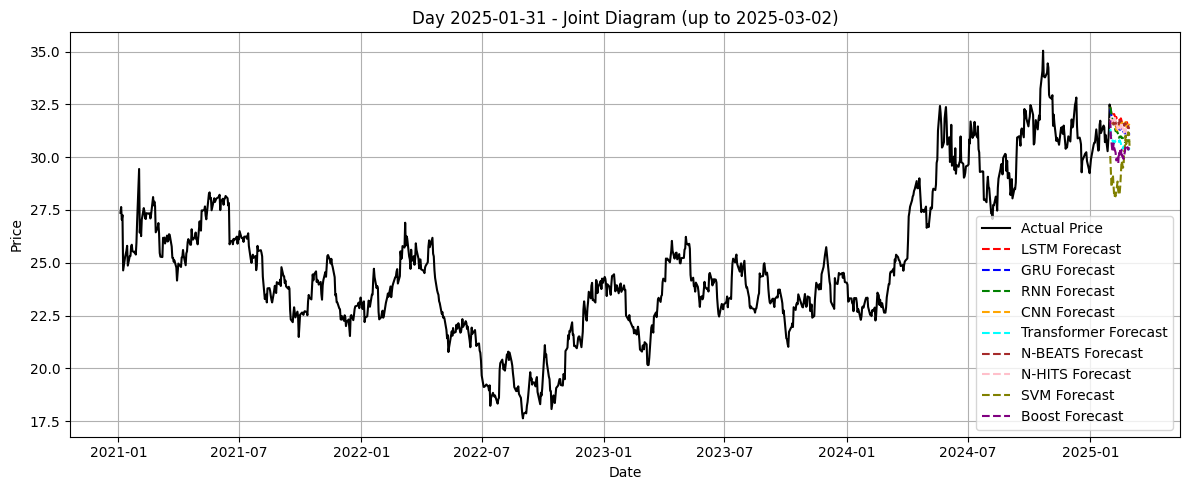

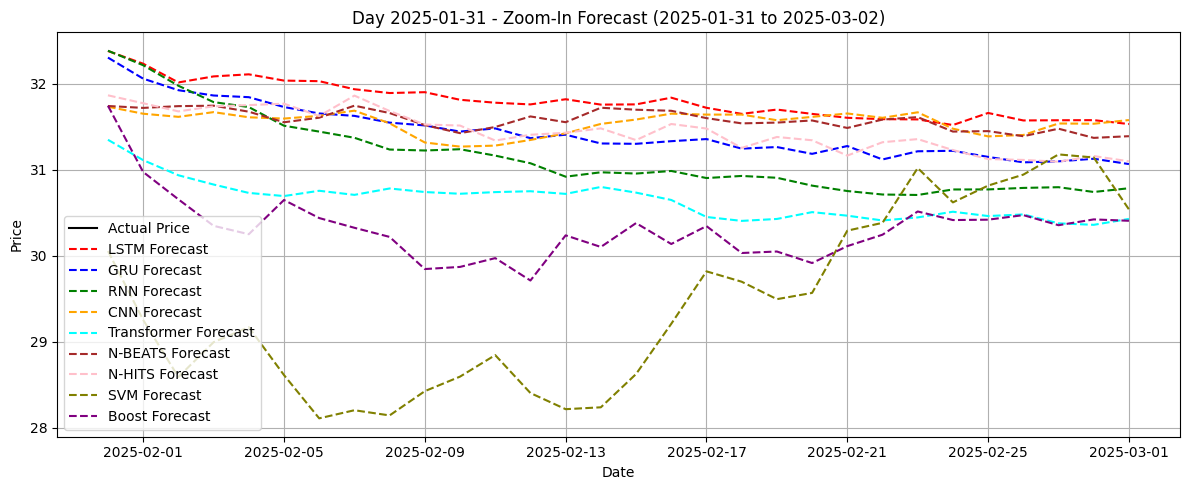


===== ROLLING FC HEAD =====
    ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
240   2025-01-02            28.994883           29.438478           29.544843   
241   2025-01-03            29.306379           28.855274           29.319309   
242   2025-01-04            29.339579           29.230506           29.657818   
243   2025-01-05            29.093368           29.520648           29.542958   
244   2025-01-06            28.987211           29.033200           29.635805   
245   2025-01-07            29.262831           28.869210           29.359278   
246   2025-01-08            29.582209           29.240636           29.603759   
247   2025-01-09            30.204626           29.462123           29.994271   
248   2025-01-10            29.947314           29.620323           30.397042   
249   2025-01-11            30.353213           29.735842           30.929594   
250   2025-01-12            30.251933           30.193019           30.824608   

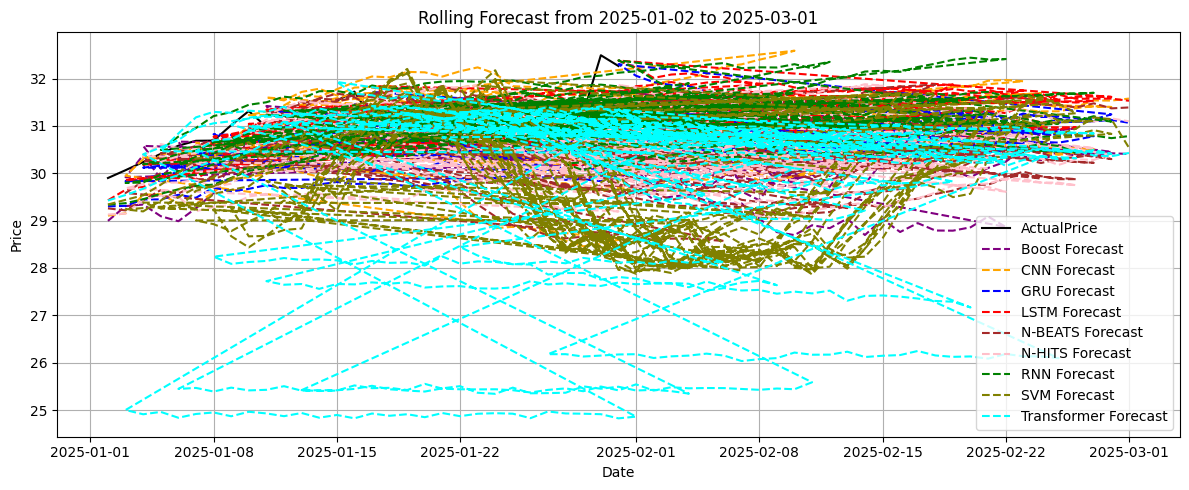


=== PLOTS for 2025-01-01 to 2025-03-01 ===


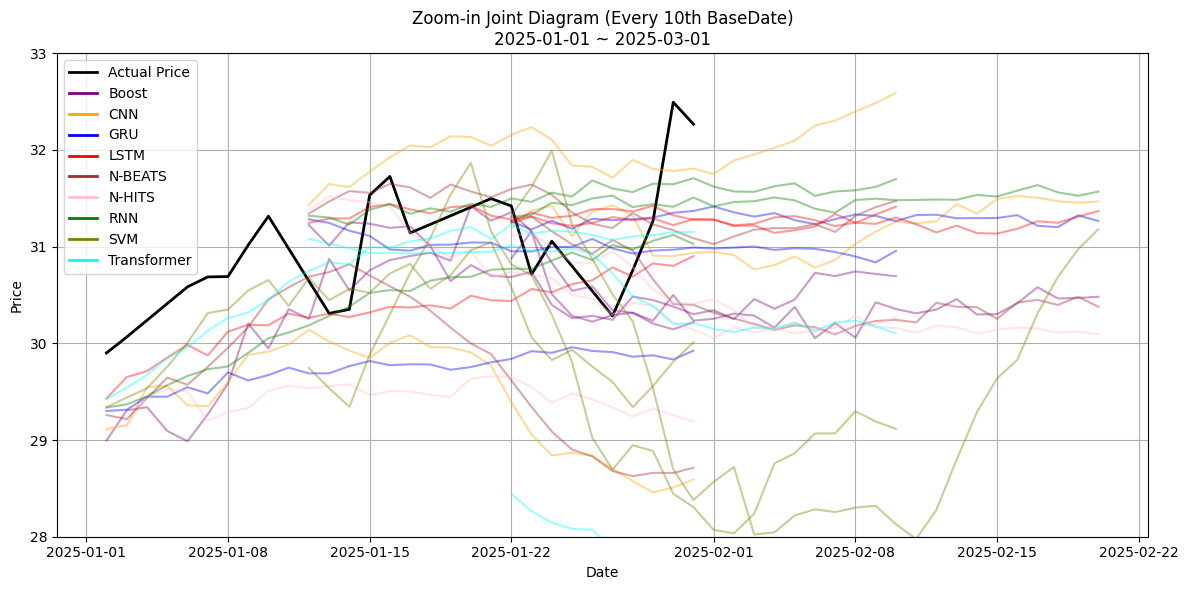

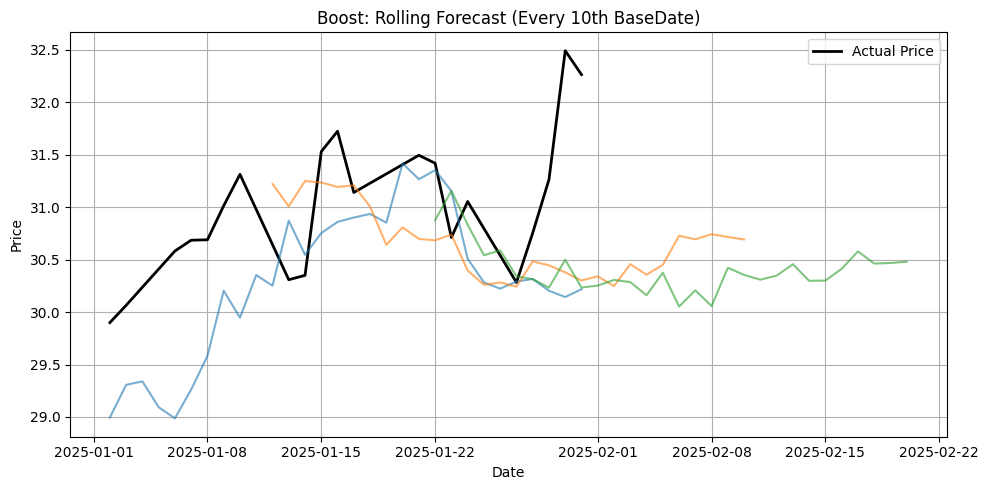

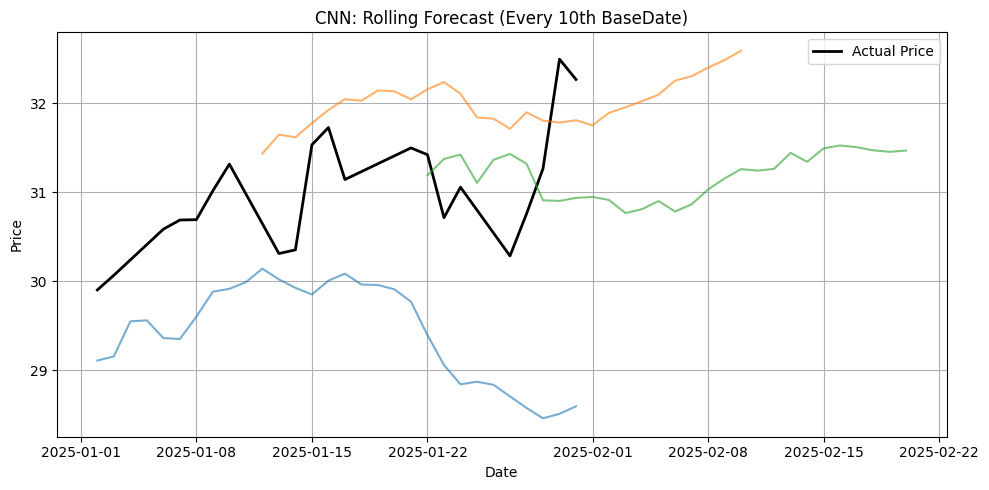

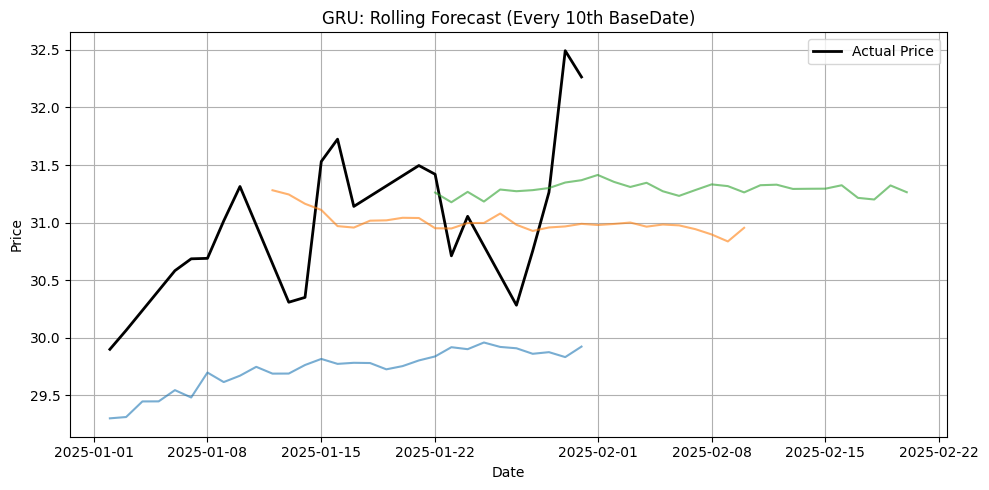

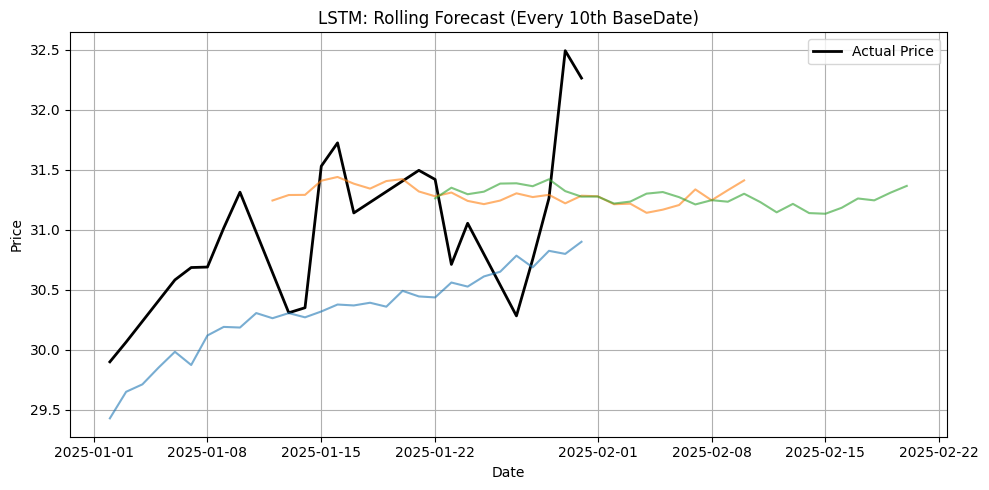

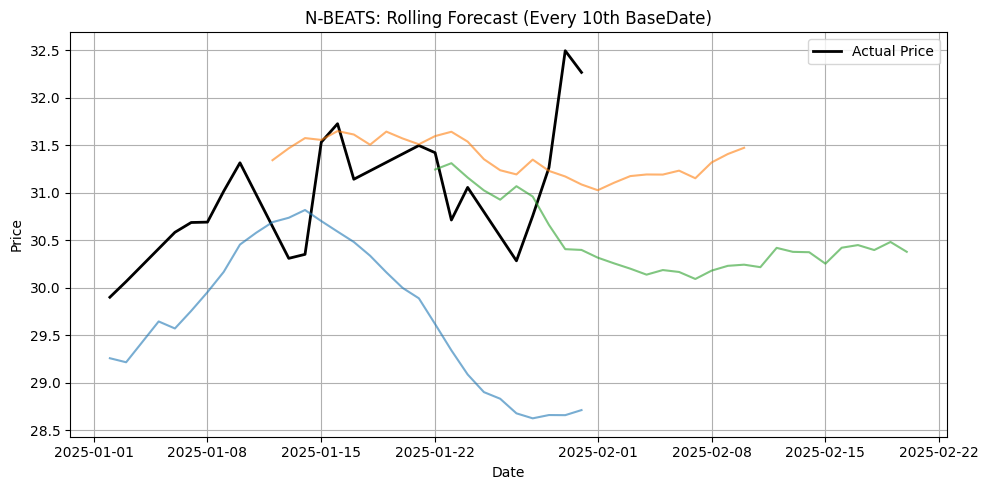

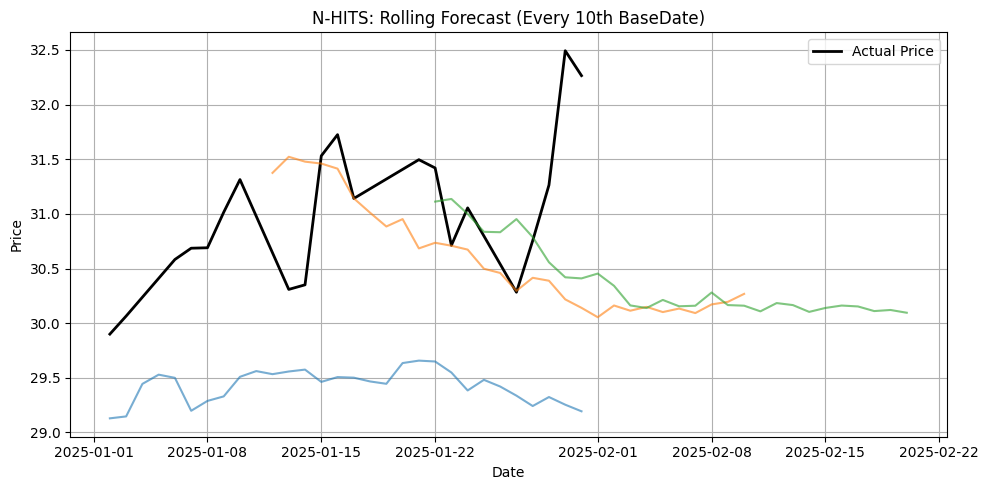

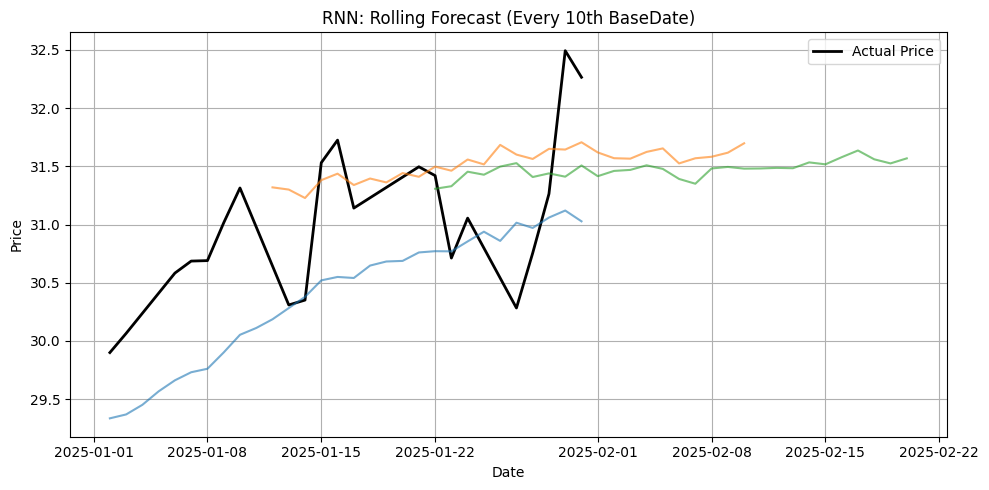

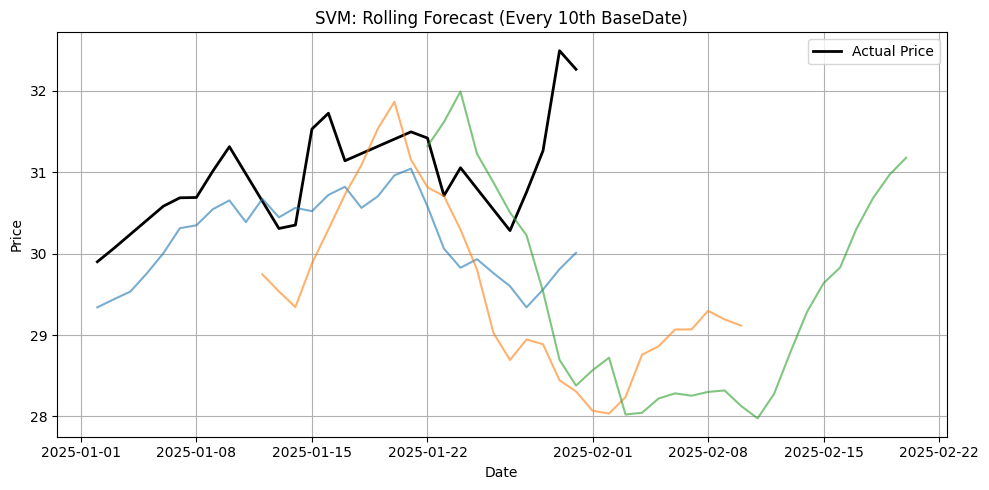

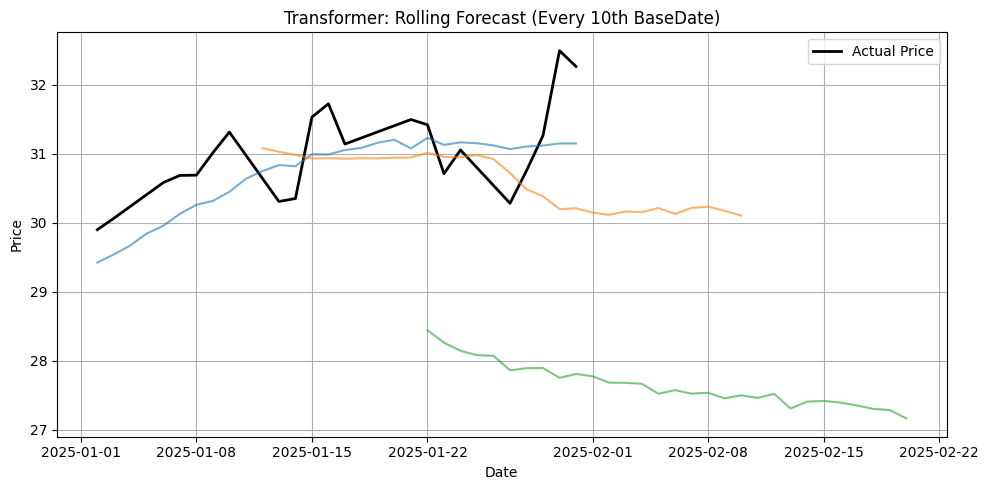


=== PLOTS for 2025-01-01 to 2025-02-01 ===


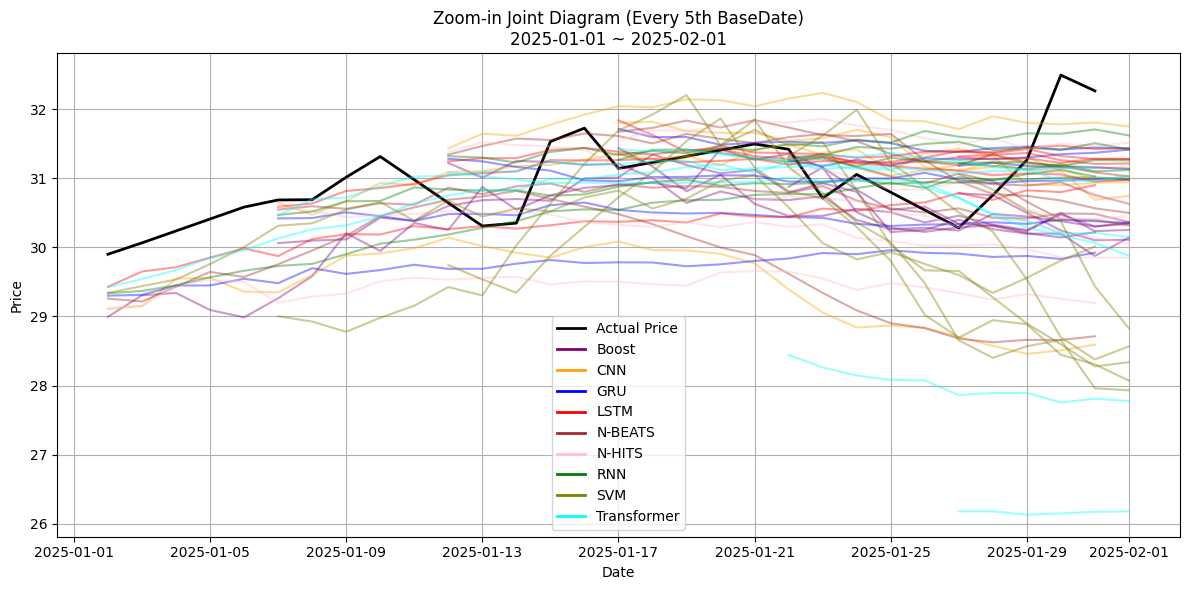

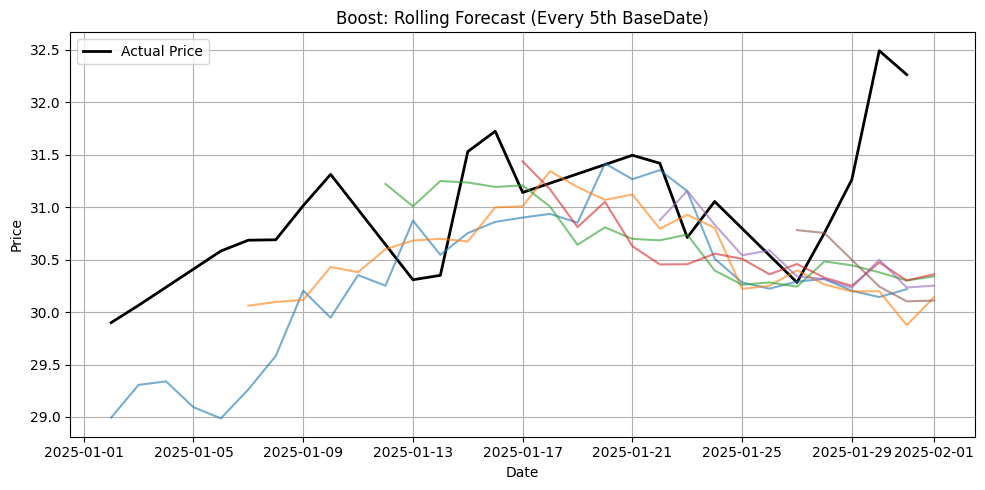

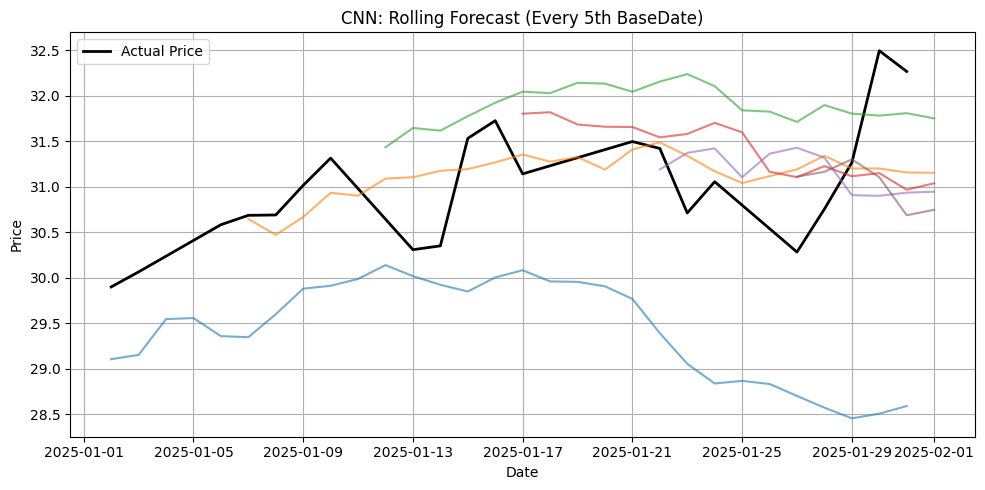

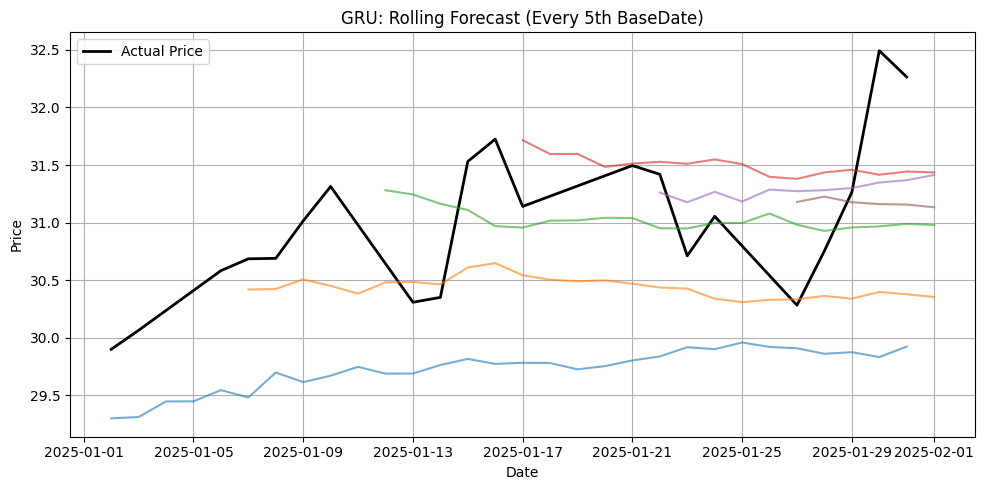

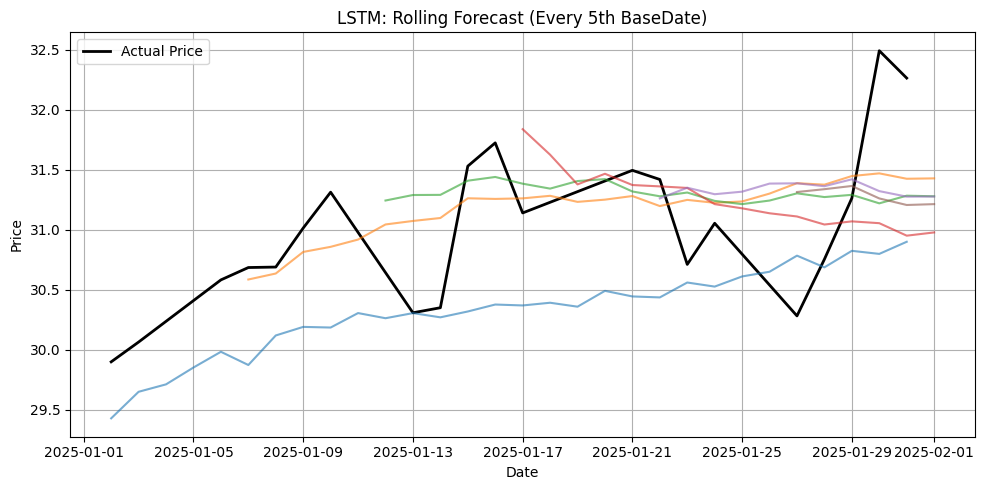

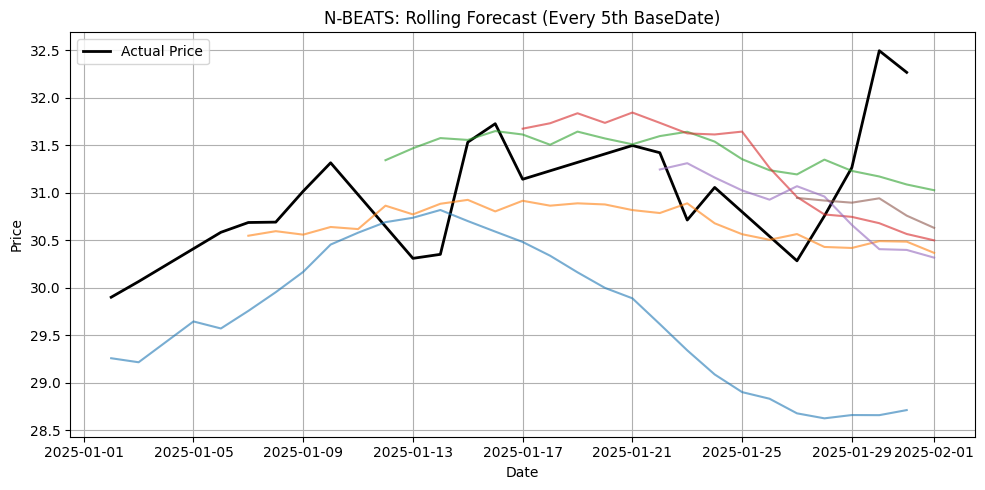

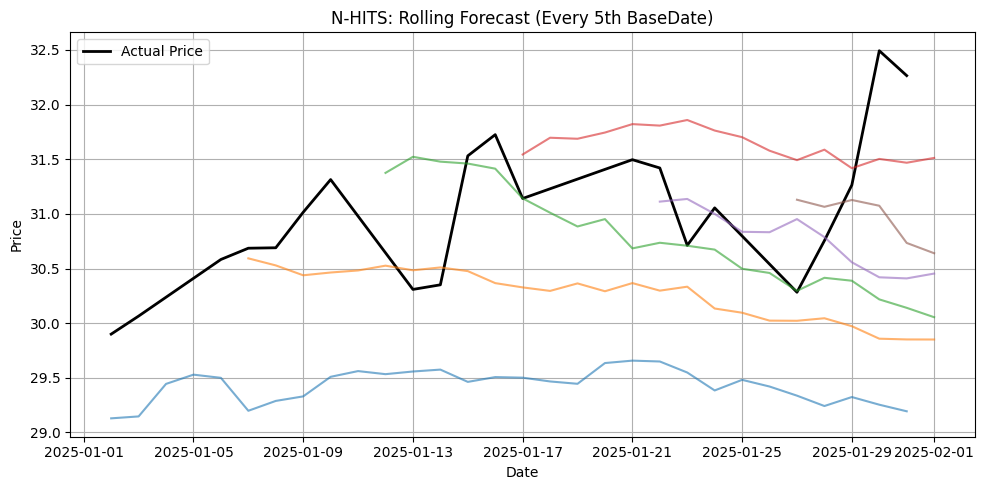

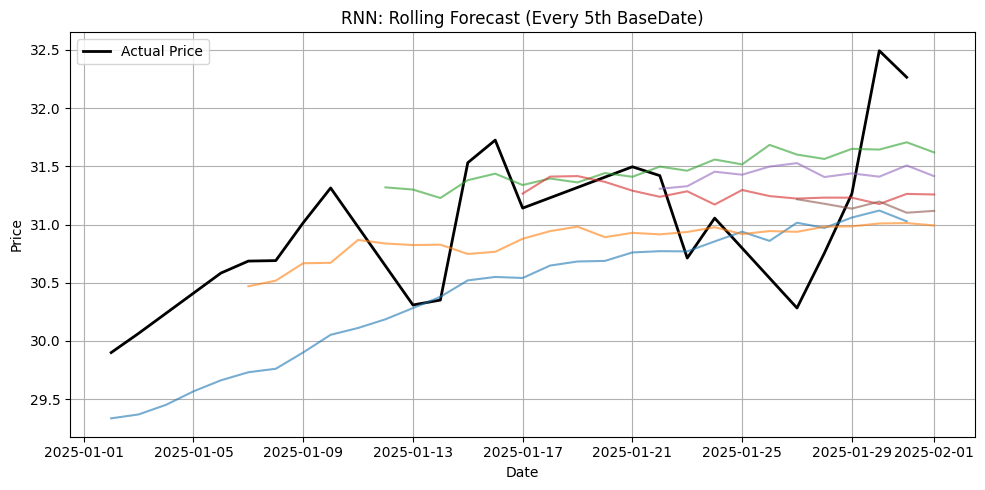

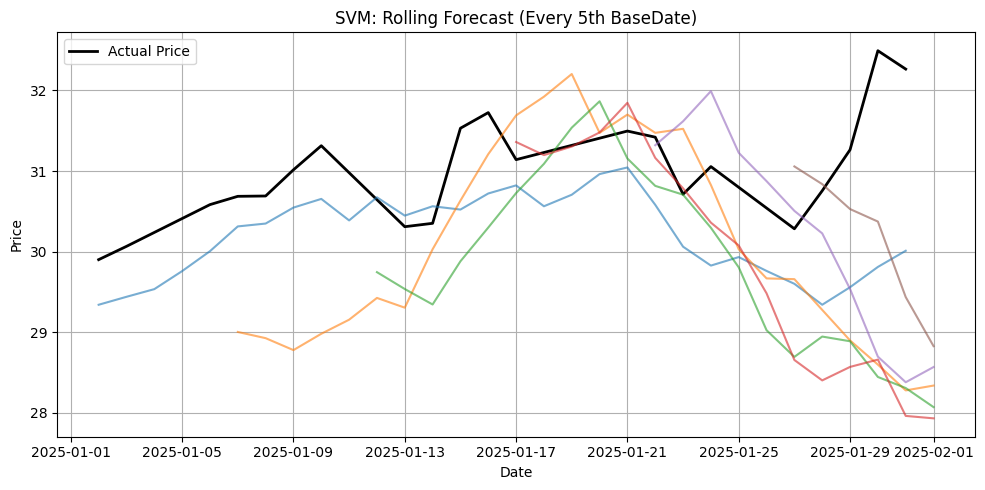

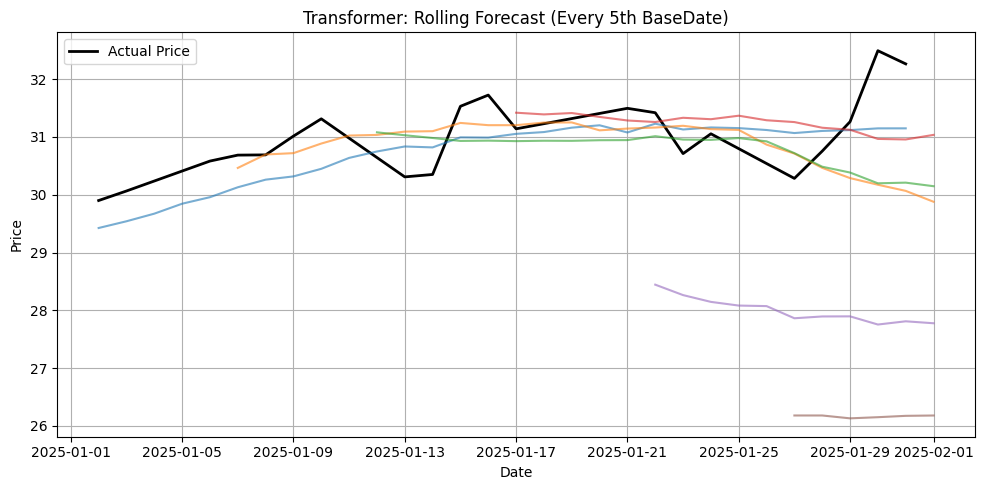


=== PLOTS for 2025-02-01 to 2025-03-01 ===


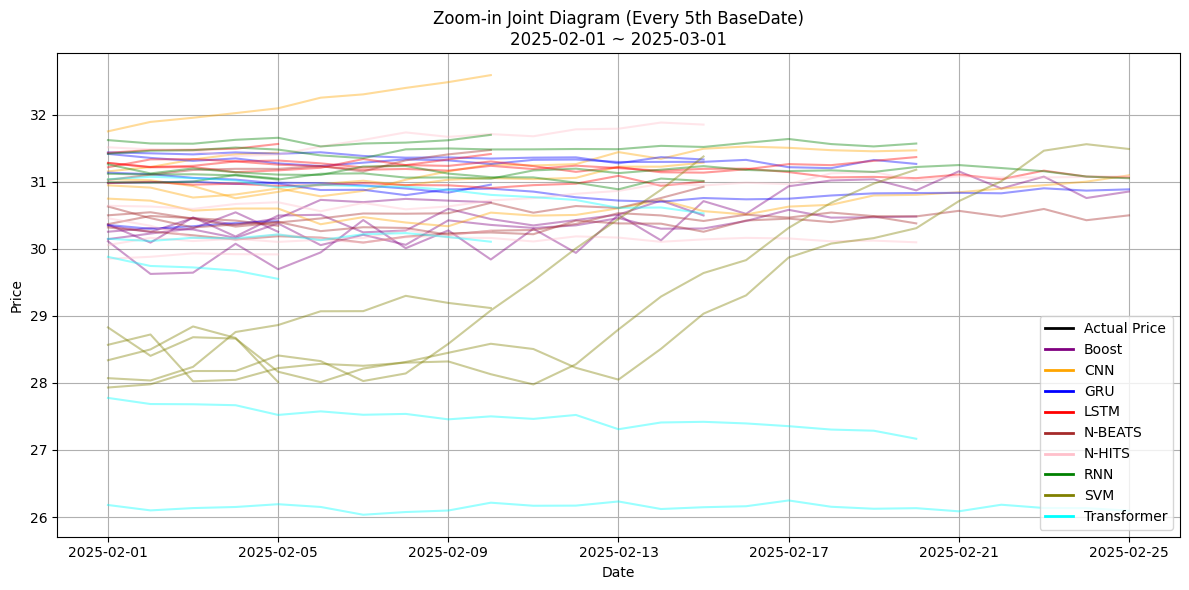

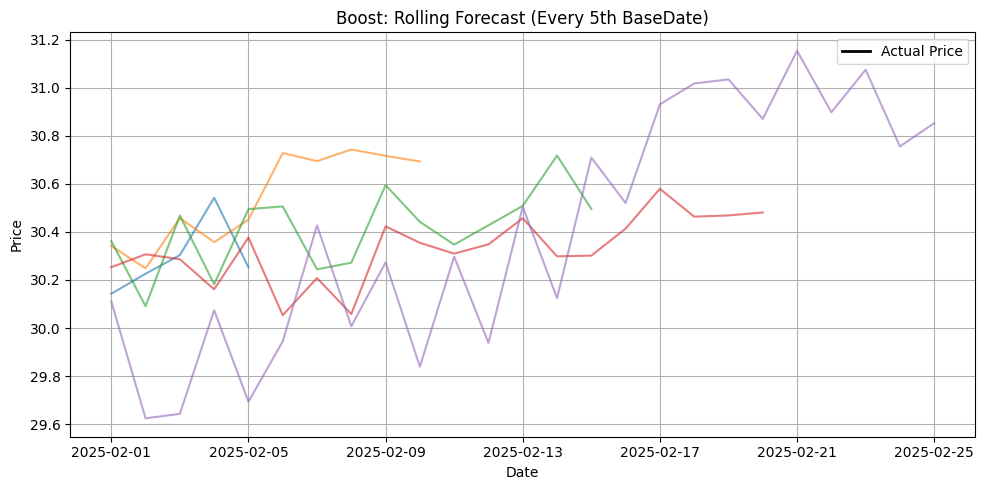

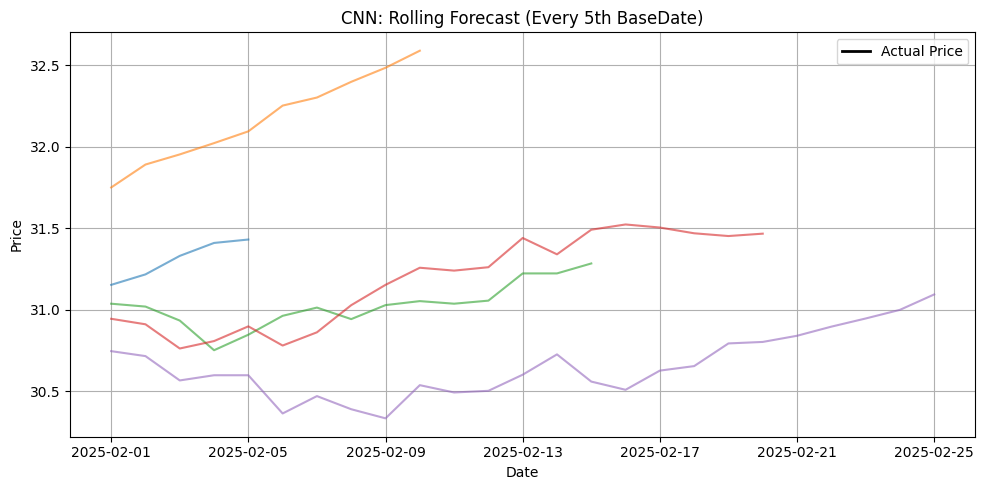

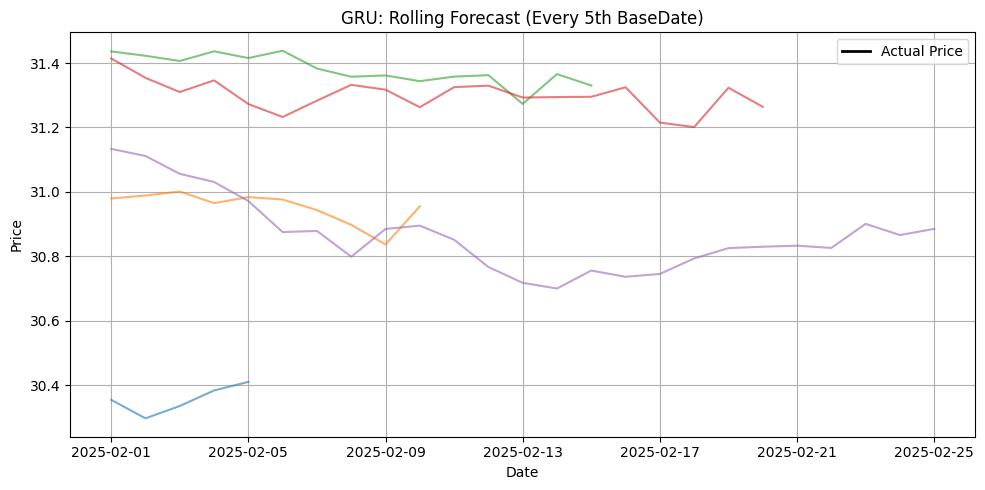

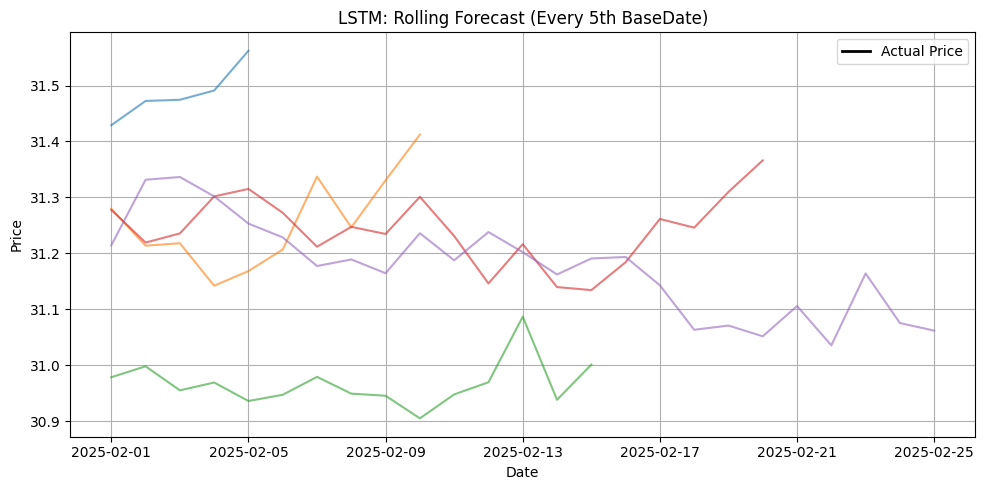

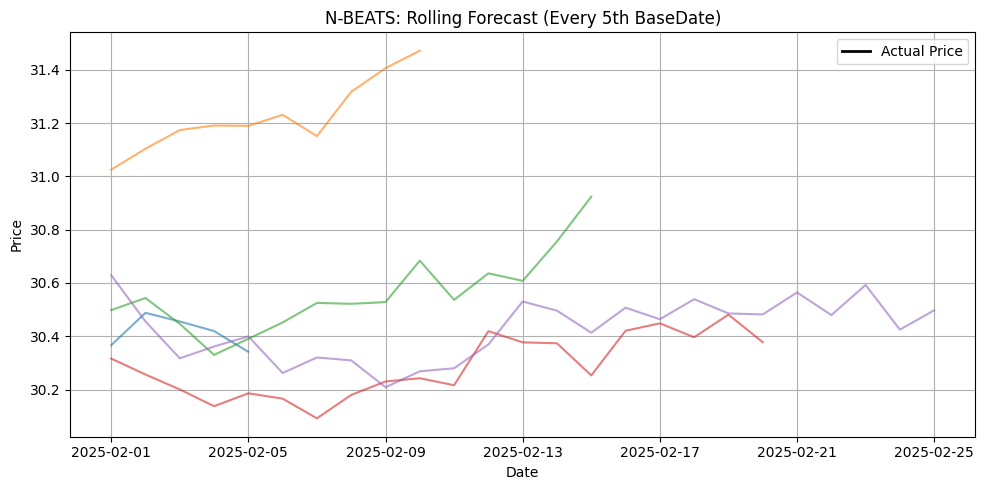

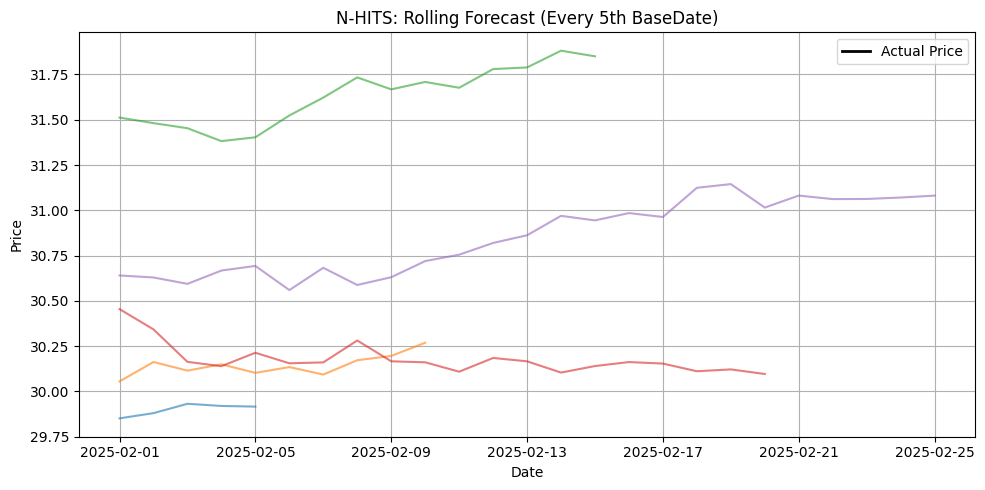

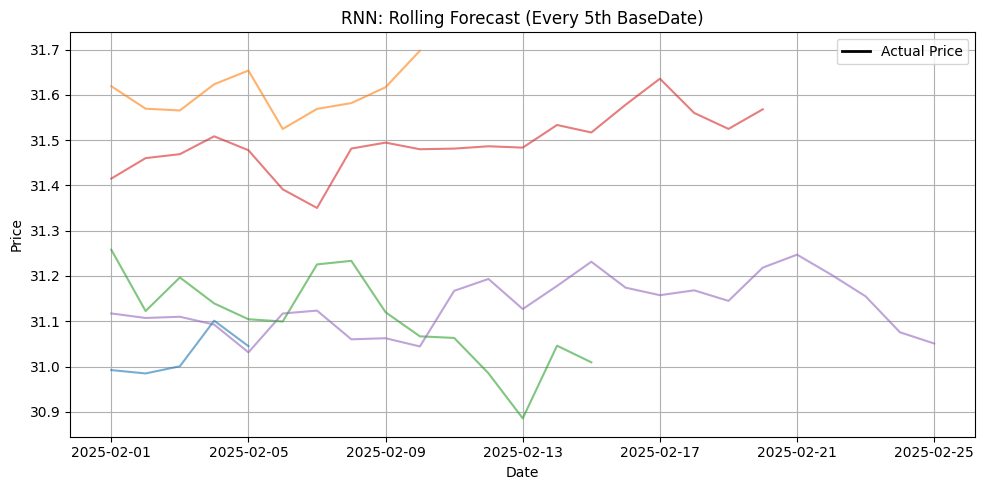

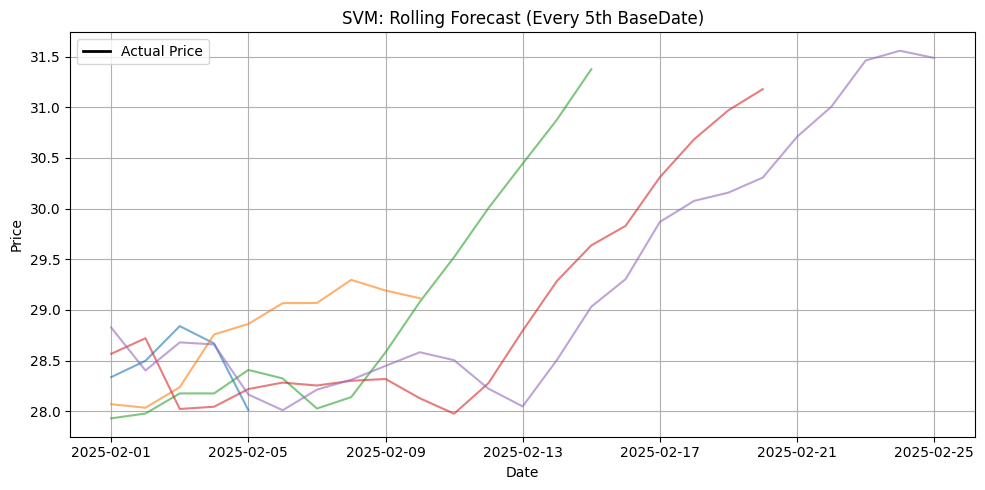

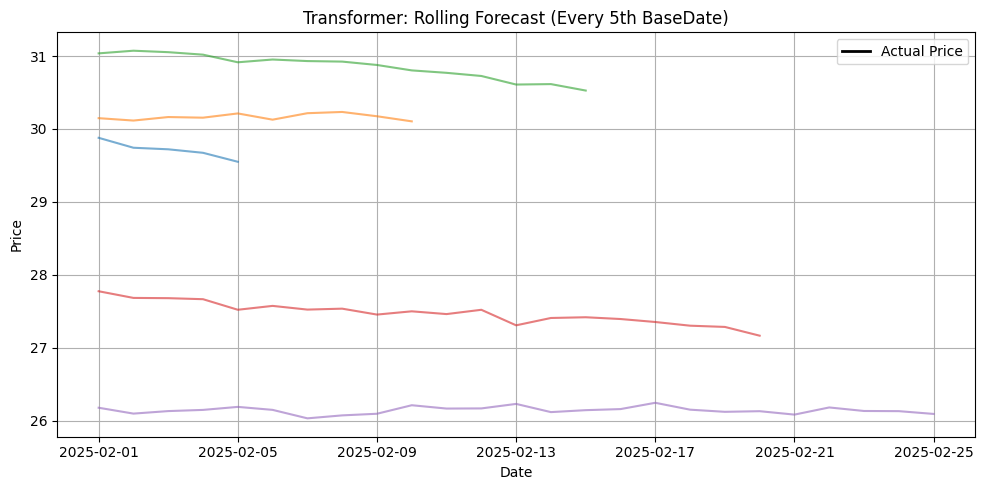


All done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Extra for the final zoom-in diagrams
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

############################################
# 1. GLOBAL SETTINGS
############################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35
NUM_EPOCHS = 1500
BEST_MODELS_DIR = "."  # directory where the .pt/.pkl model files are stored

############################################
# 2. Basic Data Preprocessing
############################################
def load_and_scale_data(train_csv, complete_csv):
    df_trainval = pd.read_csv(train_csv)
    df_trainval["Date"] = pd.to_datetime(df_trainval["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_trainval.columns:
            df_trainval.drop(columns=[col], errors="ignore", inplace=True)

    for c in features:
        if c not in df_trainval.columns:
            df_trainval[c] = np.nan
        else:
            df_trainval[c] = df_trainval[c].astype(str).str.replace(",", "", regex=True)
            df_trainval[c] = pd.to_numeric(df_trainval[c], errors="coerce")

    df_trainval.sort_values("Date", inplace=True)
    df_trainval.reset_index(drop=True, inplace=True)

    train_cutoff = pd.to_datetime("2024-08-01")
    val_cutoff   = pd.to_datetime("2024-12-31")
    test_cutoff  = pd.to_datetime("2025-01-01")

    df_train = df_trainval[df_trainval["Date"] < train_cutoff].copy()
    df_val   = df_trainval[(df_trainval["Date"] >= train_cutoff) & (df_trainval["Date"] <= val_cutoff)].copy()
    df_test  = df_trainval[df_trainval["Date"] >= test_cutoff].copy()

    # Fit scaler on train only
    df_train_nonan = df_train.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_train_nonan[features])

    # Transform train
    df_train_scaled = df_train.copy()
    if not df_train_nonan.empty:
        df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

    # Transform val
    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    # Transform test
    df_test_scaled = df_test.copy()
    train_mins = df_train_nonan[features].min()
    df_test_filled = df_test_scaled[features].fillna(train_mins)
    df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

    df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

    # Load complete CSV for final rolling
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for c in ["Vol.", "Change %"]:
        if c in df_complete.columns:
            df_complete.drop(columns=[c], inplace=True)
    for f in features:
        df_complete[f] = df_complete[f].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3. Utility: Sequence & Slices
############################################
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

############################################
# 4. Model Definitions
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat= x.reshape(x.size(0), -1)
            forecast=0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

############################################
# 5. Classes for Model Loading
############################################
class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, model_save_name):
    """Load a PyTorch model from file, raise if not found."""
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[PyTorch] Loading existing {model_type} from {model_save_name}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(model_save_name, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, model_save_name):
    """Load a scikit-learn model from .pkl, raise if not found."""
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[sklearn] Loading {model_type} => {model_save_name}")
    loaded= joblib.load(model_save_name)
    return SklearnWrapper(loaded)

############################################
# 6. Forecasting utilities
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    df_sub= df_actual.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub)< window:
        return None
    df_sub[features]= df_sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(df_sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """Full-blind forecast with random noise each day."""
    def add_noise_4d(pred_unscaled, std=0.005):
        noise= np.random.normal(0.0, std, size=pred_unscaled.shape)
        return np.clip(pred_unscaled+ noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    current_date= pd.to_datetime(start_date)

    for i in range(horizon):
        X_input= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled= model(X_input).cpu().numpy()[0]
        pred_unscaled= scaler.inverse_transform(pred_scaled.reshape(1,-1))[0]
        pred_noisy= add_noise_4d(pred_unscaled, noise_std)

        dayx= current_date+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_noisy[0],
            "Pred_Open_unscaled":  pred_noisy[1],
            "Pred_High_unscaled":  pred_noisy[2],
            "Pred_Low_unscaled":   pred_noisy[3]
        })

        # shift rolling buffer
        pred_noisy_scaled= scaler.transform(pred_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], pred_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

############################################
# 7. Rolling approach (LOAD only)
############################################
def plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_actual):
    """
    Creates 2 plots: 
      1) Joint Diagram up to day_i + horizon_days
      2) Zoomed diagram from day_i to day_i + horizon_days
    """
    df_sorted= df_actual.copy()
    df_sorted.sort_values("Date", inplace=True)
    day_end= day_i+ pd.Timedelta(days=horizon_days)

    mask= (df_sorted["Date"]<= day_end)
    df_plot= df_sorted.loc[mask].copy()

    # 1) Joint Diagram
    plt.figure(figsize=(12,5))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", label="Actual Price")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[fcdf["ForecastDate"]<= day_end].copy()
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname,"gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Joint Diagram (up to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Zoom-In
    plt.figure(figsize=(12,5))
    maskz= (df_plot["Date"]>= day_i)&(df_plot["Date"]<= day_end)
    df_zoom= df_plot.loc[maskz].copy()
    if not df_zoom.empty:
        plt.plot(df_zoom["Date"], df_zoom["Price"], color="black", label="Actual Price")
    for mname, fcdf in daily_fcst_dict.items():
        sub= fcdf[(fcdf["ForecastDate"]>=day_i)&(fcdf["ForecastDate"]<=day_end)]
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname,"gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Zoom-In Forecast ({day_i.date()} to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def rolling_train_validate_predict_moe(
    df_full,
    scaler_obj,
    model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=True
):
    """
    Loads each model from pre-saved files for each day in [start_pred..end_pred],
    and produces a forecast with optional daily plots. 
    We only produce daily plots on the final rolling day (to reduce clutter).
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    # scale entire dataset
    df_scaled_all= df_sorted.copy()
    df_scaled_all[features]= df_scaled_all[features].fillna(method="ffill").fillna(method="bfill")
    df_scaled_all[features]= scaler_obj.transform(df_scaled_all[features])

    date_range= pd.date_range(start_pred, end_pred, freq="D")
    all_records= []

    for i, day_i in enumerate(date_range):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  Loading models for cutoff {train_cutoff_i.date()} / {val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} with noise")

        # 1) Load each model from file
        model_dict= {}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        # 2) Forecast
        daily_fcst_dict= {}
        for mt, net in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model= net,
                df_actual= df_sorted,  # unscaled
                start_date= day_i,
                window= WINDOW_SIZE,
                horizon= horizon_days,
                device= device,
                scaler= scaler_obj,
                noise_std=0.05
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst_dict[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst_dict[mt]= pd.DataFrame()

        # see actual
        row_actual= df_sorted[df_sorted["Date"]== day_i]
        if not row_actual.empty:
            print(f"  Actual price: {row_actual['Price'].values[0]:.4f}")

        # 3) Only plot daily diagrams on the last rolling day
        if do_daily_plots and (day_i == date_range[-1]):
            plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_sorted)

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 8. Plot final rolling forecast
############################################
def plot_final_rolling_fc(final_rolling_fcst, df_actual, from_d, to_d):
    if final_rolling_fcst.empty:
        print("No final rolling forecast data. Exiting.")
        return

    df_act= df_actual.copy()
    df_act.sort_values("Date", inplace=True)
    mask= (df_act["Date"]>= from_d)&(df_act["Date"]<= to_d)
    df_a= df_act[mask].copy()

    plt.figure(figsize=(12,5))
    plt.plot(df_a["Date"], df_a["Price"], color="black", label="ActualPrice")

    color_map= {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for m in final_rolling_fcst["Model"].unique():
        df_m= final_rolling_fcst[final_rolling_fcst["Model"]== m].copy()
        df_m= df_m[(df_m["ForecastDate"]>=from_d)&(df_m["ForecastDate"]<= to_d)]
        if not df_m.empty:
            plt.plot(df_m["ForecastDate"], df_m["Pred_Price_unscaled"],
                     color=color_map.get(m,"gray"), linestyle="--", label=f"{m} Forecast")

    plt.title(f"Rolling Forecast from {from_d.date()} to {to_d.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 9. Additional Diagrams
############################################
def plot_joint_10day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot
):
    """
    Single figure: Actual Price + multiple model forecasts from every 10th BaseDate,
    with y-axis restricted to [28..33].
    """
    # color map
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
    ].copy()

    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base_dates = [bd for i,bd in enumerate(unique_base) if i % 10==0]  # every 10th date

    plt.figure(figsize=(12,6))
    # Actual
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

    # Legend
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.ylim(28, 33)  # restrict y-axis
    plt.title(f"Zoom-in Joint Diagram (Every 10th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_each_model_10days(
    final_rolling_fcst,
    df_actual,
    start_date_plot,
    end_date_plot
):
    """
    Creates individual plots (one per model) of rolling forecasts from every 10th BaseDate
    for the date range [start_date_plot : end_date_plot]. 
    (No y-limit enforced here, unless you specifically want to add it as well.)
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<=end_date_plot)
    ].copy()

    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base = [bd for i,bd in enumerate(unique_base) if i % 10==0]

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        plt.figure(figsize=(10,5))
        # Actual
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        for bd in chosen_base:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd= df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
            if len(df_bd)==0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every 10th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

############################################
# 10. MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale data
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Perform rolling approach: LOAD (no training), 
    #    only daily plots on the final rolling day (2025-01-31)
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full=df_complete_all,
        scaler_obj=scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-08-01"),
        start_val_cutoff=pd.to_datetime("2024-12-31"),
        start_pred=pd.to_datetime("2025-01-02"),
        end_pred=pd.to_datetime("2025-01-31"),
        horizon_days=30,
        do_daily_plots=True   # but effectively only for the final day
    )

    # 3) Final rolling forecast plot
    print("\n===== ROLLING FC HEAD =====")
    print(final_rolling_fc.head(50))
    plot_final_rolling_fc(
        final_rolling_fc,
        df_complete_all, 
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-03-01")
    )

    # 4) Additional diagrams
    # A) 2025-01-01 to 2025-03-01 => Zoom-in joint diagram with every 10th base date
    #    and y-axis = [28..33]. Then nine model-by-model diagrams with every 10th base date
    print("\n=== PLOTS for 2025-01-01 to 2025-03-01 ===")
    plot_joint_10day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )
    plot_each_model_10days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-03-01")
    )

    # B) 2025-01-01 to 2025-02-01 => No changes => same old approach (every 5th base date, no y-limit)
    def plot_joint_5day_forecasts_zoom_in(final_rolling_fcst, df_actual,
                                          start_date_plot, end_date_plot, base_date_freq=5):
        """
        Original function that uses base_date_freq=5, with no y-limit enforced.
        """
        color_map = {
            "LSTM": "red",
            "GRU": "blue",
            "RNN": "green",
            "CNN": "orange",
            "EnhancedLSTM": "magenta",
            "Transformer": "cyan",
            "N-BEATS": "brown",
            "N-HITS": "pink",
            "SVM": "olive",
            "GPR": "teal",
            "Boost": "purple"
        }
        df_plot = df_actual[
            (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
        ].copy()

        unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
        chosen_base_dates = [bd for i,bd in enumerate(unique_base) if i % base_date_freq==0]

        plt.figure(figsize=(12,6))
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        models = final_rolling_fcst["Model"].unique()
        for m in models:
            df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
            c = color_map.get(m, "gray")
            for bd in chosen_base_dates:
                df_bd = df_m[df_m["BaseDate"]==bd].copy()
                df_bd = df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
                if len(df_bd)==0: 
                    continue
                plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

        legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
        for m in models:
            legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
        plt.legend(handles=legend_elems, loc="best")

        plt.title(f"Zoom-in Joint Diagram (Every {base_date_freq}th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_each_model_5days(final_rolling_fcst, df_actual,
                              start_date_plot, end_date_plot, base_date_freq=5):
        """
        Original function that uses base_date_freq=5, with no y-limit enforced.
        """
        models = sorted(final_rolling_fcst["Model"].unique())
        df_plot = df_actual[
            (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<=end_date_plot)
        ].copy()

        unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
        chosen_base = [bd for i,bd in enumerate(unique_base) if i % base_date_freq==0]

        for m in models:
            df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
            plt.figure(figsize=(10,5))
            plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

            for bd in chosen_base:
                df_bd = df_m[df_m["BaseDate"]==bd].copy()
                df_bd= df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<=end_date_plot)]
                if len(df_bd)==0:
                    continue
                plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

            plt.title(f"{m}: Rolling Forecast (Every {base_date_freq}th BaseDate)")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    print("\n=== PLOTS for 2025-01-01 to 2025-02-01 ===")
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01"),
        base_date_freq=5
    )
    plot_each_model_5days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-02-01"),
        base_date_freq=5
    )

    # C) 2025-02-01 to 2025-03-01 => also no changes => same old approach (every 5th base date)
    print("\n=== PLOTS for 2025-02-01 to 2025-03-01 ===")
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=5
    )
    plot_each_model_5days(
        final_rolling_fc,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-02-01"),
        end_date_plot=pd.to_datetime("2025-03-01"),
        base_date_freq=5
    )

    print("\nAll done.")
